# Iceland Aerial Peprocessing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import hipp
import os
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import rasterio
import  numpy as np

## Settings

In [3]:
paths: dict[str, Path] = {}
dir = Path("/mnt/summer/USERS/DEHECQA/history/data_prep/iceland/aerial_images/1980_08_22")
paths["dir"] = dir

paths["raw_images"] = dir / "raw_images"
paths["preproc_images"] = dir / "preprocessed_images"
paths["crop_images"] = dir / "cropped_images"
paths["fiducial_templates"] = dir / "fiducial_templates"
paths["qc"] = dir / "qc"
paths["detected_fiducials"] = paths["raw_images"] / "detected_fiducial_markers.csv"
paths["detected_pseudo_fiducials"] = paths["raw_images"] / "detected_pseudo_fiducial_markers.csv"
paths["tf_detected_fiducials"] = paths["preproc_images"] / "detected_fiducial_markers.csv"
paths["crop_detected_fiducials"] = paths["crop_images"] / "detected_fiducial_markers.csv"
paths["intrinsics"] = dir / "camera_model_intrinsics.csv"
paths["extrinsics"] = dir / "camera_model_extrinsics.csv"
paths["footprint"] = dir / "images_footprint.geojson"
paths["dir"] = dir

# others settings
QUICKVIEWS_FACTOR = 0.2
MAX_WORKERS = 4
OVERWRITE = False

## Downloading the dataset

The dataset is available here : https://gatt.natt.is/geonetwork/srv/eng/catalog.search#/metadata/ea2bdf44-31d3-4628-a64e-b702d0ada27e
Here we rotate all images of 90° clockwise to align them with the calibration report.

In [49]:
if False:
    # rotate all tif images of 90° clockwise to align them with the calibration report 
    for raster_path in tqdm(list(paths["raw_images"].glob("*.tif")), desc="Rotate images"):
        with rasterio.open(raster_path) as src:
            data = src.read()
            profile = src.profile
            transform = src.transform

        # Rotate 90° clockwise
        rotated = np.rot90(data, -1, axes=(1, 2))

        # Update metadata
        profile.update({
            "height": rotated.shape[1],
            "width": rotated.shape[2],
        })

        with rasterio.open(raster_path, "w", **profile) as dst:
            dst.write(rotated)


    hipp.tools.generate_quickviews(paths["raw_images"], QUICKVIEWS_FACTOR, max_workers=MAX_WORKERS, overwrite=OVERWRITE)

Rotate images:   0%|                                                                                                     | 0/125 [00:00<?, ?it/s]

Generating quickviews: 100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:15<00:00,  1.64image/s]


## Creating the camera model intrinsics file

To create the `camera_model_intrinscis.csv` file we wile look at the calibration report. 
!IMPORTANT! we have previously rotate the image to match the calibration report orientation.

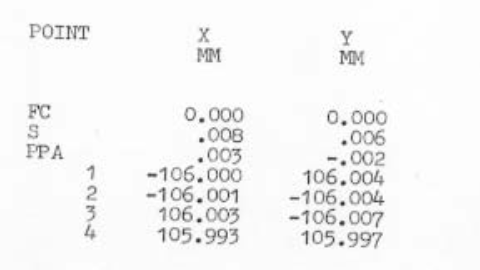

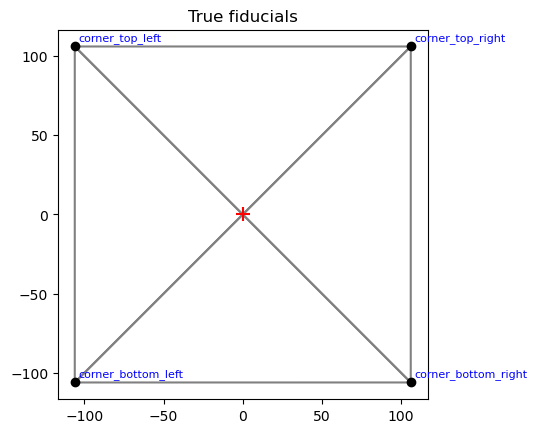

In [4]:
focal_length = 151.78
pixel_pitch = 0.02

fiducial_coords = [
    (-106.000, -106.004),
    (-106.001, 106.004),
    (106.003, 106.007),
    (105.993, -105.997),
    (0.003, 0.002) # ppa
]
intrinsics = hipp.Intrinsics.from_list(focal_length, pixel_pitch, fiducial_coords)
intrinsics.to_csv(paths["intrinsics"])
hipp.aerial.qc.plot_true_fiducials(intrinsics.true_fiducials_mm)

## Fiducial templates creation

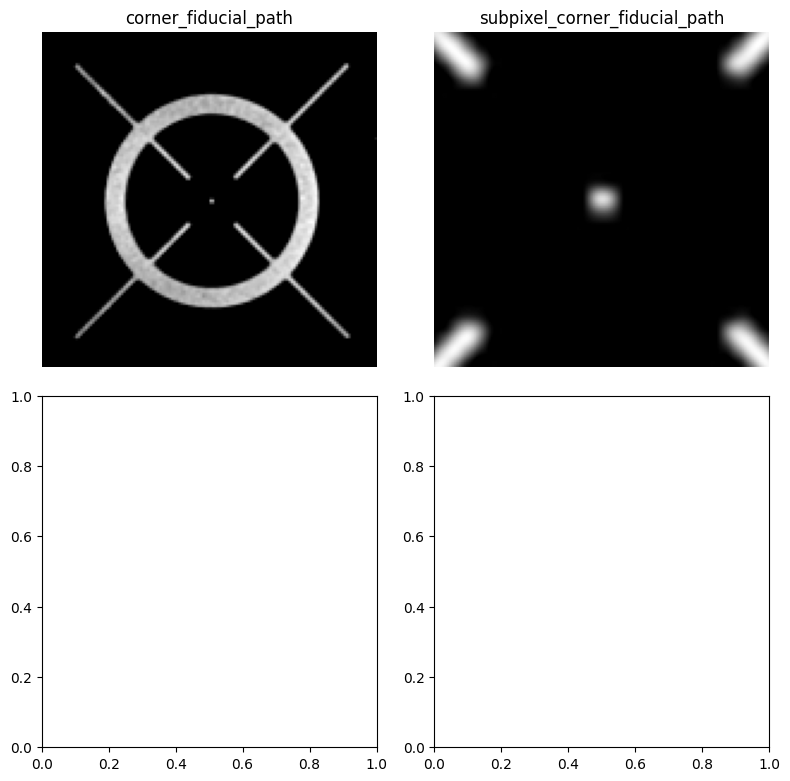

In [50]:
first_image_path = sorted(paths["raw_images"].glob("*.tif"))[1]  
saved_coords_corner = {'fiducial_coordinate': (613, 11286), 'subpixel_center_coordinate': (480, 482)}

hipp.aerial.create_fiducial_templates(first_image_path, paths["fiducial_templates"], corner=True, distance_around_fiducial=70)
hipp.aerial.qc.plot_fiducial_templates(paths["fiducial_templates"])

## Fiducial detection

Fiducial detections: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:50<00:00,  2.47Image/s]
/home/godinlu/github/hipp/src/hipp/aerial/core.py:343: UserWarning: Principal point could not be computed for 2 detection(s): ['F-9426.tif', 'F-9458.tif']
  warnings.warn(


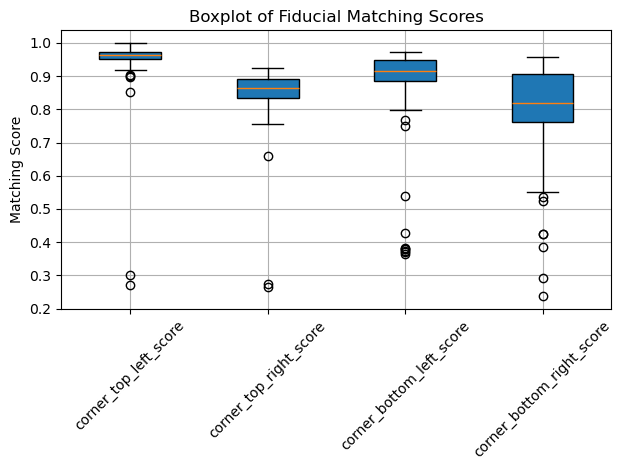

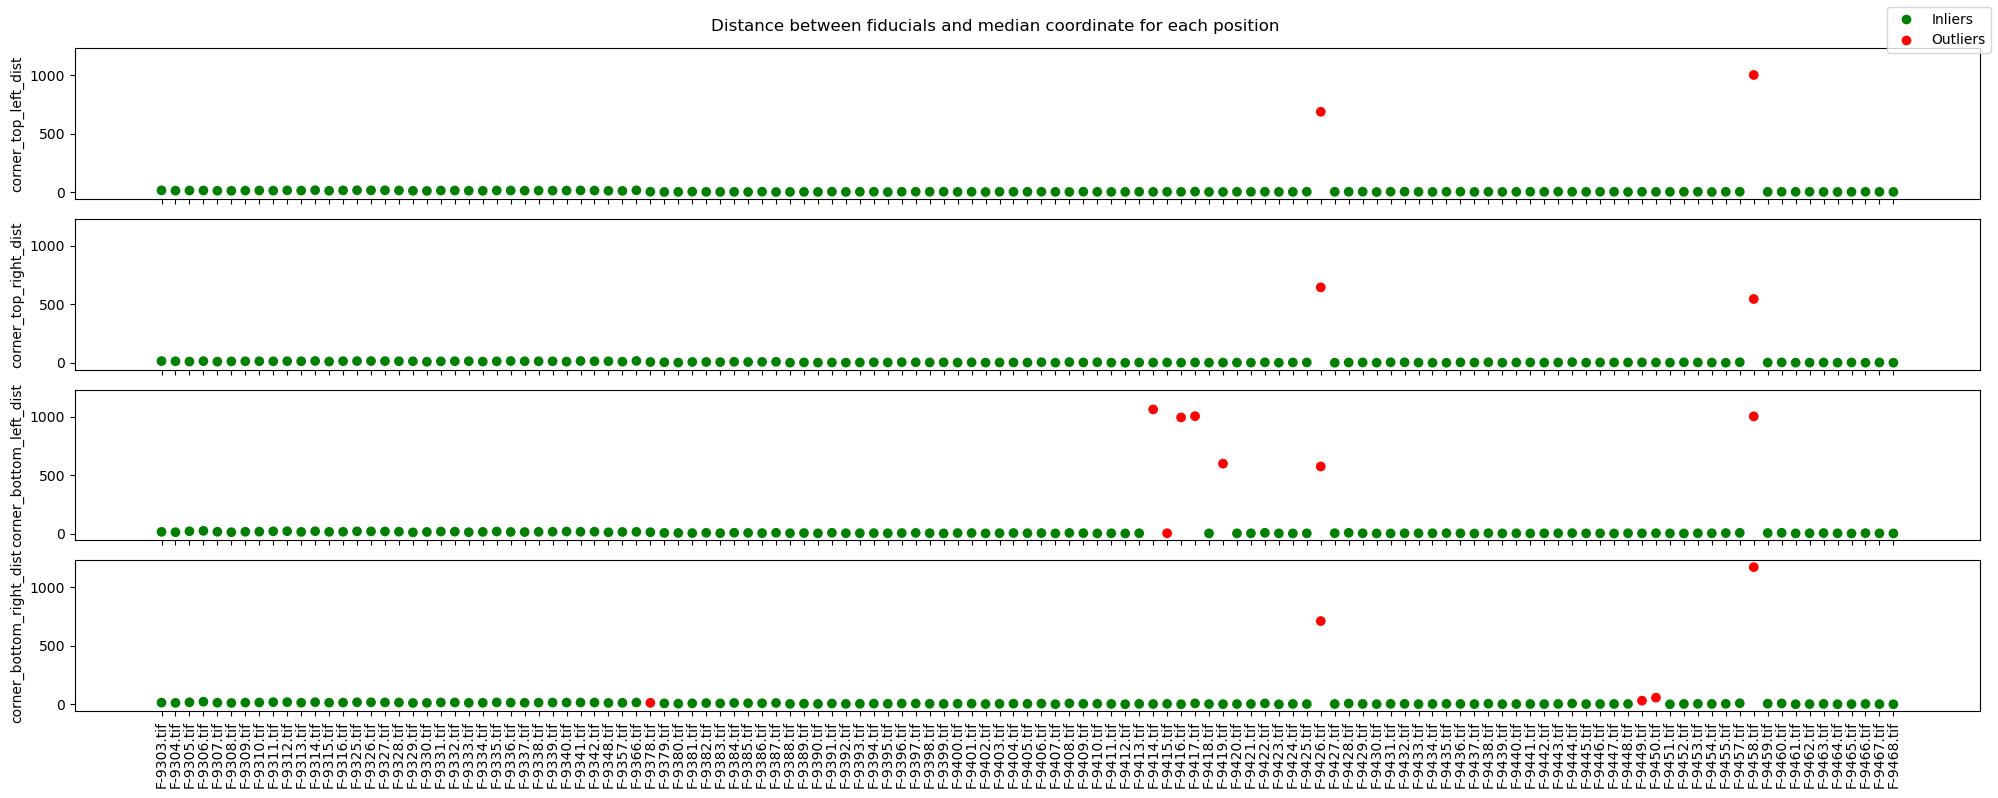

In [4]:
detected_fiducials_df = hipp.aerial.iter_detect_fiducials(paths["raw_images"], paths["fiducial_templates"], grid_size=7, max_workers=MAX_WORKERS)

# filter detection and save them into a csv
filtered_detected_fiducials_df = hipp.aerial.filter_detected_fiducials(detected_fiducials_df)
filtered_detected_fiducials_df.round(2).to_csv(paths["detected_fiducials"])

# plot matching score
output_plot_path = paths["qc"] / "detection_score_boxplot.png"
hipp.aerial.qc.plot_detection_score_boxplot(detected_fiducials_df, show=True, output_plot_path=output_plot_path)

# plot fiducials filtering
output_plot_path = paths["qc"] / "fiducials_filtering.png"
hipp.aerial.qc.plot_fiducials_filtering(detected_fiducials_df,filtered_detected_fiducials_df, show=True, output_plot_path=output_plot_path)

# plot individuals detection
output_dir = paths["qc"] / "individual_detections"
hipp.aerial.qc.generate_detection_qc_plots(paths["raw_images"], detected_fiducials_df, output_dir)

Here we have a problem for 8 detections where too much point have been removed to compute the principal point. To deal with that we will use pseudo fiducials markers.

## Pseudo Fiducials Markers Templates Creation

midside_left {'coordinate': (150, 6742), 'center_coordinate': (30, 96)}
midside_top {'coordinate': (5848, 1016), 'center_coordinate': (99, 26)}
midside_right {'coordinate': (11584, 6715), 'center_coordinate': (165, 96)}
midside_bottom {'coordinate': (5872, 12452), 'center_coordinate': (101, 158)}


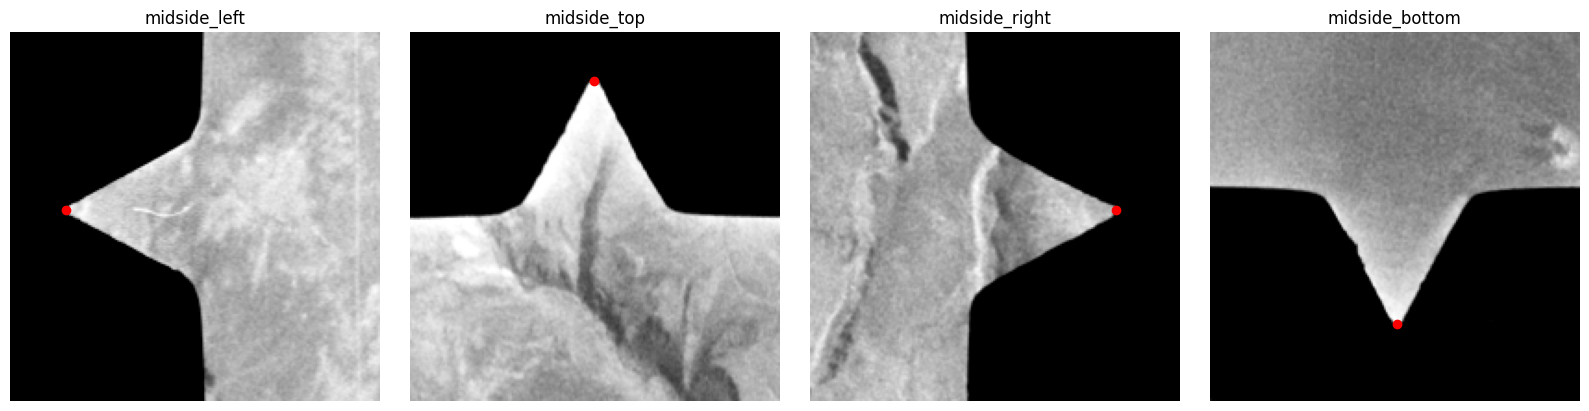

In [56]:
saved_coords = {
    "midside_left": {'coordinate': (150, 6742), 'center_coordinate': (30, 96)},
    "midside_top": {'coordinate': (5848, 1016), 'center_coordinate': (99, 26)},
    "midside_right": {'coordinate': (11584, 6715), 'center_coordinate': (165, 96)},
    "midside_bottom": {'coordinate': (5872, 12452), 'center_coordinate': (101, 158)},

}
for side, coords in saved_coords.items():
    tmp_coords = hipp.aerial.create_pseudo_fiducial_templates(first_image_path, paths["fiducial_templates"], side, **coords) 
    print(side, tmp_coords)

hipp.aerial.qc.plot_pseudo_fiducial_templates(paths["fiducial_templates"])

## Pseudo Fiducials detection

Fiducial detections: 100%|██████████████████████████████████████████████████████████████████████████████████| 125/125 [00:56<00:00,  2.20Image/s]
/home/godinlu/github/hipp/src/hipp/aerial/core.py:239: UserWarning: Principal point could not be computed for 2 detection(s): ['F-9378.tif', 'F-9379.tif']
  warnings.warn(


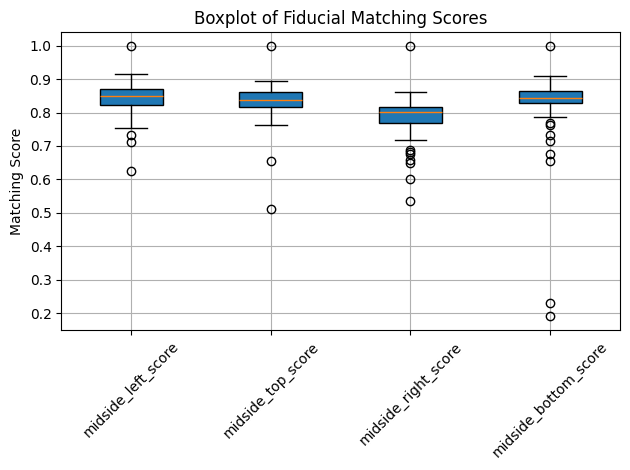

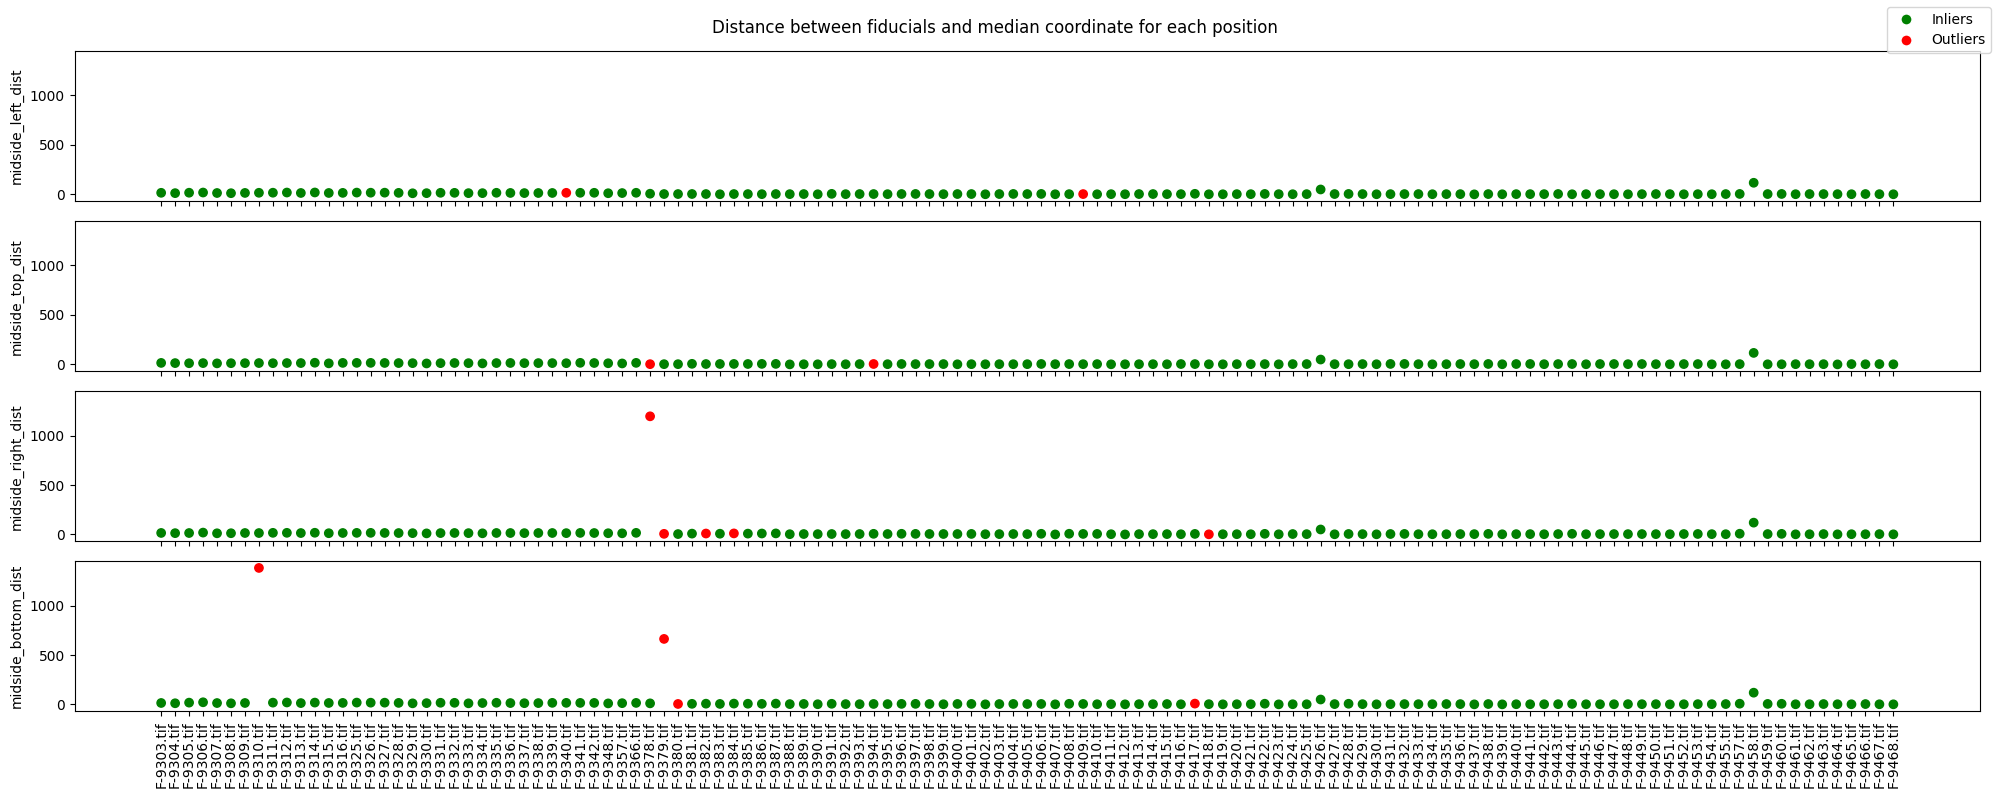

In [54]:

detected_fiducials_df = hipp.aerial.iter_detect_pseudo_fiducials(paths["raw_images"], paths["fiducial_templates"], grid_size=7, max_workers=MAX_WORKERS)

# filter detection and save them into a csv
filtered_detected_fiducials_df = hipp.aerial.filter_detected_fiducials(detected_fiducials_df)
filtered_detected_fiducials_df.round(2).to_csv(paths["detected_pseudo_fiducials"])

# plot matching score
output_plot_path = paths["qc"] / "pseudo_detection_score_boxplot.png"
hipp.aerial.qc.plot_detection_score_boxplot(detected_fiducials_df, show=True, output_plot_path=output_plot_path)

# plot fiducials filtering
output_plot_path = paths["qc"] / "pseudo_fiducials_filtering.png"
hipp.aerial.qc.plot_fiducials_filtering(detected_fiducials_df,filtered_detected_fiducials_df, show=True, output_plot_path=output_plot_path)

# plot individuals detection
output_dir = paths["qc"] / "individual_pseudo_detections"
hipp.aerial.qc.generate_detection_qc_plots(paths["raw_images"], detected_fiducials_df, output_dir)



compute transformation for all images, without images without principal points

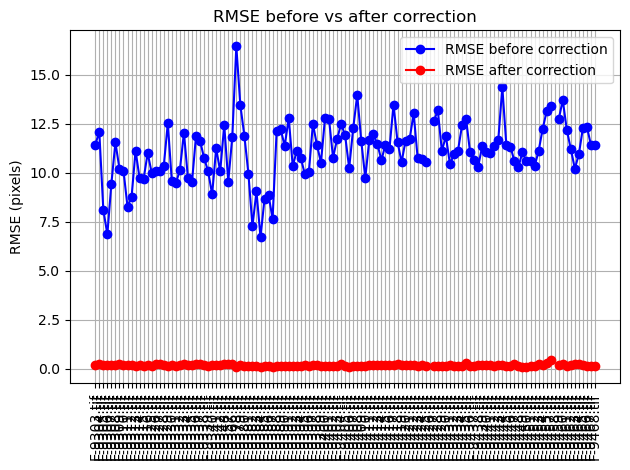

In [5]:
ref_image_id = "F-9303.tif"

intrinsics = hipp.Intrinsics.from_csv(paths["intrinsics"])
image_square_dim = int(228.6 / intrinsics.pixel_pitch) - 5 

fiducials_df = pd.read_csv(paths["detected_fiducials"], index_col="image_id")
pseudo_fiducials_df = pd.read_csv(paths["detected_pseudo_fiducials"], index_col="image_id")

# remove detection without principal points
fiducials_df_valid = fiducials_df.loc[~fiducials_df["principal_point_x"].isna()]

transformations = hipp.aerial.compute_transformations(fiducials_df_valid, intrinsics.true_fiducials_mm, image_square_dim, intrinsics.pixel_pitch)

# compute the target pseudo fiducials coordinate references
target_pseudo_fiducials = hipp.aerial.fiducials.warp_fiducial_coordinates(pseudo_fiducials_df.loc[ref_image_id], transformations[ref_image_id])

# compute all transformation between pseudo fiducials and this target pseudo fiducials
for image_id in fiducials_df.loc[fiducials_df["principal_point_x"].isna()].index:
    transformations[image_id] = hipp.aerial.fiducials.compute_fiducial_transformation(pseudo_fiducials_df.loc[image_id], target_pseudo_fiducials)

paths["tf_detected_fiducials"].parent.mkdir(parents=True, exist_ok=True)
hipp.aerial.warp_fiducials_df(fiducials_df, transformations).round(2).to_csv(paths["tf_detected_fiducials"])

hipp.aerial.qc.plot_fiducials_correction(fiducials_df, transformations, intrinsics.true_fiducials_mm, intrinsics.pixel_pitch)

In [61]:
hipp.aerial.iter_image_restitution(
    paths["raw_images"], 
    paths["preproc_images"], 
    transformations,
    image_square_dim=image_square_dim,
    max_workers=MAX_WORKERS,
    overwrite=OVERWRITE
)
hipp.tools.generate_quickviews(paths["preproc_images"], factor=QUICKVIEWS_FACTOR, max_workers=MAX_WORKERS, overwrite=OVERWRITE)

0it [00:00, ?it/s]


## Step 10 : Preprocessed with only crop around the center of fiducials

In [6]:
intrinsics = hipp.Intrinsics.from_csv(paths["intrinsics"])
image_square_dim = int(228.6 / intrinsics.pixel_pitch) - 5 

fiducials_df = pd.read_csv(paths["detected_fiducials"], index_col="image_id")
pseudo_fiducials_df = pd.read_csv(paths["detected_pseudo_fiducials"], index_col="image_id")

for image_id in fiducials_df.loc[fiducials_df["principal_point_x"].isna()].index:
    fiducials_df.loc[image_id, ["principal_point_x", "principal_point_y"]] = pseudo_fiducials_df.loc[image_id, ["principal_point_x", "principal_point_y"]]


# we set true_fiducials_mm to None to keep only the translation for the cropping
crop_tfs = hipp.aerial.compute_transformations(fiducials_df, None, image_square_dim, intrinsics.pixel_pitch)

# save the transformed detected fiducial markers (coordinate of fiducials in preprocessed images)
os.makedirs(paths["crop_images"], exist_ok=True)
hipp.aerial.warp_fiducials_df(fiducials_df, crop_tfs).round(2).to_csv(paths["crop_detected_fiducials"])

hipp.aerial.iter_image_restitution(
    paths["raw_images"], 
    paths["crop_images"], 
    crop_tfs,
    image_square_dim=image_square_dim,
    max_workers=MAX_WORKERS,
    overwrite=OVERWRITE
)
hipp.tools.generate_quickviews(paths["crop_images"], factor=QUICKVIEWS_FACTOR, max_workers=MAX_WORKERS, overwrite=OVERWRITE)

0it [00:00, ?it/s]


## GCP

In [7]:
def read_gcp(file_path: str | Path) -> pd.DataFrame:
    """ Read a GCP (Ground Control Points) file in either .csv or .gcp format. """
    file_path = Path(file_path)
    if file_path.name.endswith(".csv"):
        return pd.read_csv(file_path)
    elif file_path.name.endswith(".gcp"):
        colonnes = [
            "gcp_label",         
            "image_file_name",        
            "x",       
            "y",    
            "x_map",
            "y_map"     
            "lon",            
            "lat",             
            "elev",      
            "lon_acc", "lat_acc", "elev_acc" 
        ]
        return pd.read_csv(file_path, sep=r"\s+", header=None, names=colonnes)
    else:
        raise ValueError(
            f"Unsupported file extension: '{file_path}'. "
            "Supported formats are .csv and .gcp"
        )
    
def transform_gcp(gcp_df: pd.DataFrame, transformation_matrixs) -> pd.DataFrame:
    """Apply geometric transformation to the GCP pixel coordinates (x, y)
    using the corresponding transformation matrix for each image."""

    def apply_affine(row):
        transform = transformation_matrixs[row["image_file_name"]]
        x, y = hipp.math.transform_coord((row["x"], row["y"]), transform)
        return pd.Series({"x": x, "y": y})

    transformed_df = gcp_df.copy()
    transformed_df[["x", "y"]] = transformed_df.apply(apply_affine, axis=1).round(2)

    return transformed_df

# open raw gcp and transform it to have gcp in every geometry
raw_gcp = read_gcp(paths["raw_images"] / "gcp.csv")
preprocesses_gcp = transform_gcp(raw_gcp, transformations)
cropped_gcp = transform_gcp(raw_gcp, crop_tfs)

# save the gcp 
preprocesses_gcp.to_csv(paths["preproc_images"] / "gcp.csv", index=False)
cropped_gcp.to_csv(paths["crop_images"] / "gcp.csv", index=False)

